In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

# Define U-Net architecture
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # Add more convolutional and pooling layers as needed

    # Decoder
    up2 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(concatenate([up2, conv1], axis=3))
    # Add more transposed convolutional and convolutional layers as needed

    outputs = Conv2D(1, 1, activation='sigmoid')(conv2)  # Assuming binary segmentation

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Define input shape and create model
input_shape = (256, 256, 3)  # Adjust dimensions as needed
model = unet_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using your dataset
# Example:
# model.fit(train_generator, epochs=10, validation_data=val_generator)

# Save the trained model
model.save('unet_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define transformation for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Check if dataset directory exists
dataset_root = '/content/drive/MyDrive/Pretrained'
if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"Dataset directory '{dataset_root}' not found.")

# Check if the dataset contains subdirectories
subdirectories = [d for d in os.listdir(dataset_root) if os.path.isdir(os.path.join(dataset_root, d))]
if not subdirectories:
    raise FileNotFoundError(f"No subdirectories found in '{dataset_root}'. Make sure each class has its own directory.")

# Load dataset
dataset = ImageFolder(root=dataset_root, transform=transform)

# Split dataset into train and test sets
train_set, test_set = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Define ResNet model
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, len(dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

# Train the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_set)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluate the model
resnet.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total}%")


Epoch [1/10], Loss: 1.0035
Epoch [2/10], Loss: 0.2809
Epoch [3/10], Loss: 0.1931
Epoch [4/10], Loss: 0.0981
Epoch [5/10], Loss: 0.0880
Epoch [6/10], Loss: 0.0280
Epoch [7/10], Loss: 0.0401
Epoch [8/10], Loss: 0.0392
Epoch [9/10], Loss: 0.0104
Epoch [10/10], Loss: 0.0120
Accuracy on test set: 87.5%


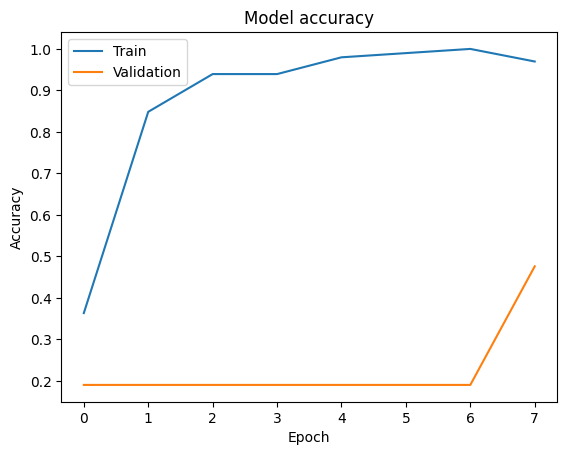

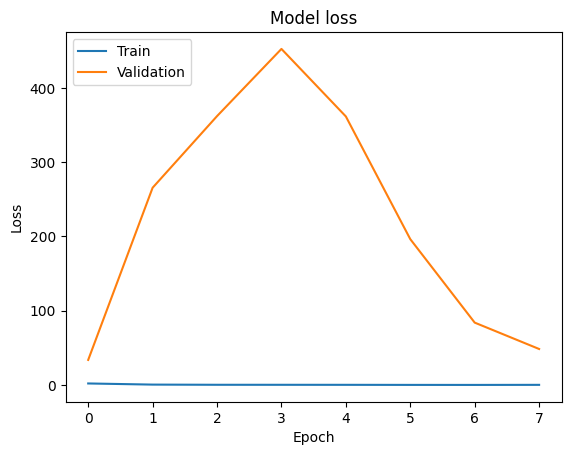

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
from PIL import Image

# Function to preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Apply the same transformation as used during training
    return image

# Function to classify the image
def classify_image(image_path, model):
    model.eval()
    image = preprocess_image(image_path).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = dataset.classes[predicted.item()]
        print("Predicted class:", predicted_class)

# Load the trained model
model = resnet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Provide the path to the image you want to classify
image_path = "/content/drive/MyDrive/try/try1/3.png"

# Call the classify_image function
classify_image(image_path, model)


Predicted class: 3VT


In [ ]:
from PIL import Image

# Function to preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Apply the same transformation as used during training
    return image

# Function to classify the image
def classify_image(image_path, model):
    model.eval()
    image = preprocess_image(image_path).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = dataset.classes[predicted.item()]
        print("Predicted class:", predicted_class)

# Load the trained model
model = resnet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Provide the path to the image you want to classify
image_path = "/content/drive/MyDrive/try/try1/e-c-i-f.png"

# Call the classify_image function
classify_image(image_path, model)


Predicted class: ECIF


In [ ]:
from PIL import Image

# Function to preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Apply the same transformation as used during training
    return image

# Function to classify the image
def classify_image(image_path, model):
    model.eval()
    image = preprocess_image(image_path).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = dataset.classes[predicted.item()]
        print("Predicted class:", predicted_class)

# Load the trained model
model = resnet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Provide the path to the image you want to classify
image_path = "/content/drive/MyDrive/try/try1/H.png"

# Call the classify_image function
classify_image(image_path, model)


Predicted class: LVOT


In [ ]:
from PIL import Image

# Function to preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Apply the same transformation as used during training
    return image

# Function to classify the image
def classify_image(image_path, model):
    model.eval()
    image = preprocess_image(image_path).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_class = dataset.classes[predicted.item()]
        print("Predicted class:", predicted_class)

# Load the trained model
model = resnet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Provide the path to the image you want to classify
image_path = "/content/drive/MyDrive/try/try1/N.png"

# Call the classify_image function
classify_image(image_path, model)


Predicted class: Normal_Heart
